In [1]:
#imports
import math
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax.example_libraries import stax
from jax.example_libraries import optimizers
import random as rd
import pickle
import os
from flax import linen as nn
import optax
from flax.training import train_state
from flax.training import checkpoints
from typing import Any, Dict
import pandas as pd
#from google.colab import files

2025-01-12 22:07:50.708666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736716070.839348     852 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736716070.865542     852 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#METODA AUTOGRAD

#Definicja Lagrangianu dla podwójnego lagrangianu liczonego w sposób analityczny
#Argumenty funkcji:
#  -q   - położenie ciała
#  -q_t - prędkość ciała
#  -m1  - masa pierwszej kuli
#  -m2  - masa drugiej kuli
#  -l1  - długość pierwszej lini
#  -l2  - długość drugiej lini
#  -g   - wartość przyśpieszenia ziemskiego
#Zwracane: wartość Lagrangianu w danym momencie.
def lagrangian_analitical(q, q_t, m1, m2, l1, l2, g):

    # Energia kinetyczna pierwszej kuli
    Ek1 = 0.5*m1*(l1*q_t[0])**2
    # Energia kinetyczna drugiej kuli
    Ek2 = 0.5*m2*((l1*q_t[0])**2 + (l2*q_t[1])**2 + 2*l1*l2*q_t[0]*q_t[1]*jnp.cos(q[0]-q[1]))

    # Energia potencjalna obu kul
    Ep = m1*g*(-1)*l1*jnp.cos(q[0]) + m2*g*(-l1*jnp.cos(q[0]) - l2*jnp.cos(q[1]))

    return Ek1 + Ek2 - Ep

#Obliczenie energi potencjalnej i kinetycznej układu na podstawie aktualnego stanu
#Argumenty funkcji:
#  -q   - położenie ciała
#  -q_t - prędkość ciała
#  -m1  - masa pierwszej kuli
#  -m2  - masa drugiej kuli
#  -l1  - długość pierwszej lini
#  -l2  - długość drugiej lini
#  -g   - wartość przyśpieszenia ziemskiego
#Zwracane:
#  -Ek  - Energia kinetyczna
#  -Ep  - Energia potencjalna
def compute_energy(q, q_t, m1=1.0, m2=1.0, l1=1.0, l2=1.0, g=9.8):
    # Energia kinetyczna pierwszej kuli
    Ek1 = 0.5*m1*(l1*q_t[0])**2
    # Energia kinetyczna drugiej kuli
    Ek2 = 0.5*m2*((l1*q_t[0])**2 + (l2*q_t[1])**2 + 2*l1*l2*q_t[0]*q_t[1]*jnp.cos(q[0]-q[1]))

    # Energia potencjalna obu kul
    Ep = m1*g*(-1)*l1*jnp.cos(q[0]) + m2*g*(-l1*jnp.cos(q[0]) - l2*jnp.cos(q[1]))


    return Ek1 + Ek2,  Ep

#Funkcja siły działającej na wahadło
def Force(t):
    return jnp.array([0, 0])

#Funkcja ma za zadanie reprezenotwanie równania różniczkowego, wynikającego z rozwiązania
#równanie Eulera-Lagrange'a
#Argumenty funkcji:
#   -lagrangian - Funkcja opisująca Lagrangian. Funkcja musi być typu ,,callable'' żeby,
#                 pochodne Lagrangianu zostały policzone.
#   -state      - Wektor zawierający wartości początkowe położenia i prędkości
#   -empty      - Aby ta funkcja mogła zostać poprawnie wywoływana w dalszej części programu
#                 koniecznym było dodanie ,,pustego'' argumentu, które nie będzie pełnił żadnej
#                 funkcji, ale pozwoli na poprawną kompilację
#Zwracane: Wektor zawiercający przyśpieszenia oraz prędkości w danym momencie.
def equation_of_motion(lagrangian, state, time=None):
    #Rozdzilenie danych startowych na położenia i prędkości
    q, q_t = jnp.split(state, 2)
    q = q.flatten()
    q_t = q_t.flatten()
    #Obliczanie przyśpieszenia na podstawie lagrangianu
    q_tt = jax.numpy.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t)) @ (
		jax.grad(lagrangian, 0)(q, q_t)
		- jax.jacfwd(jax.grad(lagrangian, 1), 0)(q, q_t) @ q_t)
    q_tt = q_tt + Force(time)
    return jnp.concatenate([q_t, q_tt])

#Funkcja wyznaczająca trajektorię ruchu przy użyciu Lagrangianu wyznaczonego
#w sposób analityczny
#Argumenty funkcji:
#   -initial_state - Początkowego położenie oraz prędkości
#   -times         - Czas wyznaczanej trajektori
#   -m1  - masa pierwszej kuli
#   -m2  - masa drugiej kuli
#   -l1  - długość pierwszej lini
#   -l2  - długość drugiej lini
#   -g   - wartość przyśpieszenia ziemskiego
#Zwraca:
#   Wektor trajektori ruchu w zależności od czasu
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m1=1.0, m2=1.0, l1=1.0, l2=1.0, g=9.8):
    lagrangian = partial(lagrangian_analitical, m1=m1, m2=m2, l1=l1, l2=l2, g=g)
    equation = partial(equation_of_motion, lagrangian)
    return odeint(equation, initial_state, times, rtol=1e-10, atol=1e-10)


In [3]:
#Funkcja obliczająca przyśpieszenie podwójnego wahadła na podstawie aktualnego położenia i prędkości.
#Argumenty funkcji:
#   -state - Początkowego położenie oraz prędkości
#   -times - Aby ta funkcja mogła zostać poprawnie wywoływana w dalszej części programu
#            koniecznym było dodanie ,,pustego'' argumentu, które nie będzie pełnił żadnej
#            funkcji, ale pozwoli na poprawną kompilację
#   -m1  - masa pierwszej kuli
#   -m2  - masa drugiej kuli
#   -l1  - długość pierwszej lini
#   -l2  - długość drugiej lini
#   -g   - wartość przyśpieszenia ziemskiego
#Zwraca:
#   Wektor trajektori ruchu w zależności od czasu
def analitical(state, time=None ,m1=1.0, m2=1.0, l1=1.0, l2=1.0, g=9.8):
    q, q_t = jnp.split(state, 2)

    sr = jnp.sin(q[0] - q[1])
    cr = jnp.cos(q[0] - q[1])
    q_tt_1 = m2*g*jnp.sin(q[1])*cr - m2*sr*(l1*(q_t[0]**2)*cr + l2*(q_t[1]**2)) - (m1 + m2)*g*jnp.sin(q[0])
    q_tt_1 = q_tt_1/(l1*(m1 + m2*sr*sr))
    q_tt_2 = (m1+m2) * (l1*(q_t[0]**2)*sr - g*jnp.sin(q[1]) + g*jnp.sin(q[0])*cr) + m2*l2*(q_t[1]**2)*sr*cr
    q_tt_2 = q_tt_2/(l2*(m1 + m2*sr*sr))
    q_tt =  jnp.stack([q_tt_1, q_tt_2])

    return jnp.concatenate((jnp.expand_dims(q_t, axis=0), jnp.expand_dims(q_tt, axis=0)), axis=0)

#Funkcja wyznaczająca trajektorię ruchu obliczoną przy użyciu analitycznie wyznaczonego
# równiania różniczkowego (funkcja analitical)
#Argumenty funkcji:
#   -initial_state - Początkowego położenie oraz prędkości
#   -times         - Czas wyznaczanej trajektori
#   -m1  - masa pierwszej kuli
#   -m2  - masa drugiej kuli
#   -l1  - długość pierwszej lini
#   -l2  - długość drugiej lini
#   -g   - wartość przyśpieszenia ziemskiego
#Zwraca:
#   Wektor trajektori ruchu w zależności od czasu
@partial(jax.jit, backend='cpu')
def solve_analitical(initial_state, times, m1=1.0, m2=1.0, l1=1.0, l2=1.0, g=9.8):
    function = partial(analitical,m1=m1, m2=m2, l1=l1, l2=l2, g=g)
    return odeint(function, initial_state, t=times, rtol=1e-10, atol=1e-10)


In [4]:
#Punkt startowy
x0 = jnp.array([np.pi/2,0,0,0], dtype=np.float32)
#Szum
noise = np.random.RandomState(0).randn(x0.size)
#Wektor czasów
t = np.linspace(0, 40, num=401, dtype=np.float32)

In [5]:
#Funkcja normalizująca kąt Wahadła theta do zakresu <0,2Pi>
def normalize(state):
    theta1 = (state[0] -  np.pi)  % (2 * np.pi) - np.pi
    theta2 = (state[1] -  np.pi)  % (2 * np.pi) - np.pi
    return jnp.array([theta1, theta2, state[2], state[3]], dtype=np.float32)
    #return state

In [6]:
#WYZNACZENIE TRAJEKTORI METODĄ AUTOGRAD ORAZ ANALITYCZNĄ

#Autograd
%time autograd_clean = jax.device_get(solve_autograd(x0, t))
autograd_clean = jax.vmap(normalize)(autograd_clean)

#Autograd z małym szumem
%time autograd_noise1 = jax.device_get(solve_autograd(x0 + 1e-10*noise, t))
autograd_noise1 = jax.vmap(normalize)(autograd_noise1)

#Autograd z dużym szumem
%time autograd_noise2 = jax.device_get(solve_autograd(x0 + 1e-5*noise, t))
autograd_noise2 = jax.vmap(normalize)(autograd_noise2)

#Analitycznie
%time analitical_clean = jax.device_get(solve_analitical(x0, t))
analitical_clean = jax.vmap(normalize)(analitical_clean)
#Analitycznie z małym szumem
%time analitical_noise1 = jax.device_get(solve_analitical(x0 + 1e-10*noise, t))
analitical_noise1 = jax.vmap(normalize)(analitical_noise1)
#Analitycznie z dużym szumem
%time analitical_noise2 = jax.device_get(solve_analitical(x0 + 1e-5*noise, t))
analitical_noise2 = jax.vmap(normalize)(analitical_noise2)

CPU times: user 6.87 s, sys: 392 ms, total: 7.27 s
Wall time: 7.68 s
CPU times: user 1.68 s, sys: 26.2 ms, total: 1.7 s
Wall time: 1.82 s
CPU times: user 1.84 s, sys: 75.6 ms, total: 1.92 s
Wall time: 2.28 s
CPU times: user 2.16 s, sys: 149 ms, total: 2.3 s
Wall time: 2.24 s
CPU times: user 71.9 ms, sys: 0 ns, total: 71.9 ms
Wall time: 88.7 ms
CPU times: user 79 ms, sys: 157 µs, total: 79.1 ms
Wall time: 110 ms


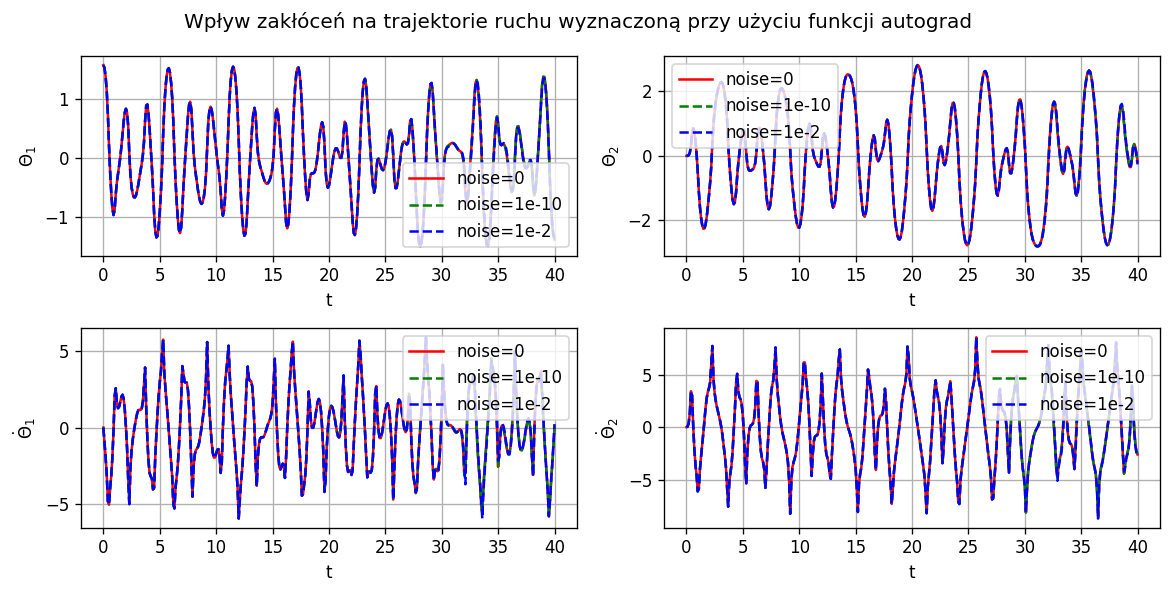

In [7]:
#WYŚWIETLENIE TRAJEKTORI (AUTOGRAD)

fig, axes = plt.subplots(2, 2, figsize=(10, 5), dpi=120)

fig.suptitle("Wpływ zakłóceń na trajektorie ruchu wyznaczoną przy użyciu funkcji autograd")

#Kąt pierwszego wahadła
axes[0,0].plot(t, autograd_clean[:, 0], 'r', label='noise=0')
axes[0,0].plot(t, autograd_noise1[:, 0], 'g--', label='noise=1e-10')
axes[0,0].plot(t, autograd_noise2[:, 0], 'b--', label='noise=1e-2')
axes[0,0].set_xlabel('t')
axes[0,0].set_ylabel('$\Theta_1$')
axes[0,0].legend()
axes[0,0].grid()

#Kąt drugiego wahadła
axes[0,1].plot(t, autograd_clean[:, 1], 'r', label='noise=0')
axes[0,1].plot(t, autograd_noise1[:, 1], 'g--', label='noise=1e-10')
axes[0,1].plot(t, autograd_noise2[:, 1], 'b--', label='noise=1e-2')
axes[0,1].set_xlabel('t')
axes[0,1].set_ylabel('$\Theta_2$')
axes[0,1].legend()
axes[0,1].grid()

#Prędkość kątowa pierwszego wahadła
axes[1,0].plot(t, autograd_clean[:, 2], 'r', label='noise=0')
axes[1,0].plot(t, autograd_noise1[:, 2], 'g--', label='noise=1e-10')
axes[1,0].plot(t, autograd_noise2[:, 2], 'b--', label='noise=1e-2')
axes[1,0].set_xlabel('t')
axes[1,0].set_ylabel('$\dot \Theta_1$')
axes[1,0].legend()
axes[1,0].grid()

#Prędkość prędkość kątowa drugiego wahadła
axes[1,1].plot(t, autograd_clean[:, 3], 'r', label='noise=0')
axes[1,1].plot(t, autograd_noise1[:, 3], 'g--', label='noise=1e-10')
axes[1,1].plot(t, autograd_noise2[:, 3], 'b--', label='noise=1e-2')
axes[1,1].set_xlabel('t')
axes[1,1].set_ylabel('$\dot \Theta_2$')
axes[1,1].legend()
axes[1,1].grid()

plt.tight_layout()

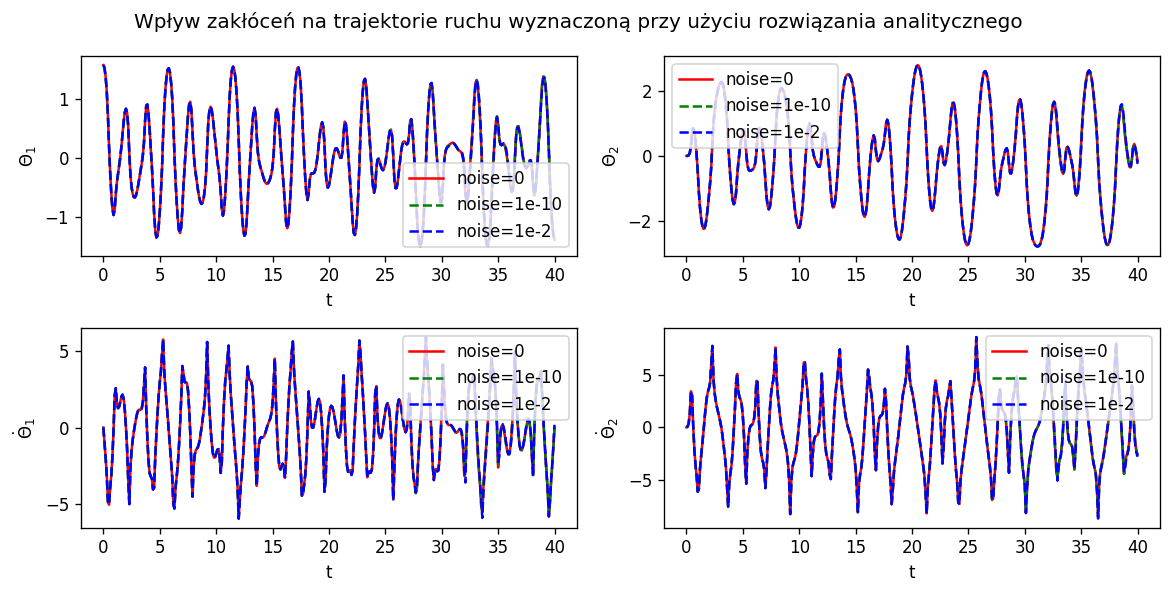

In [8]:
#WYŚWIETLENIE TRAJEKTORI (METODA ANALITYCZNA)

fig, axes = plt.subplots(2, 2, figsize=(10, 5), dpi=120)

fig.suptitle("Wpływ zakłóceń na trajektorie ruchu wyznaczoną przy użyciu rozwiązania analitycznego")

#Kąt pierwszego wahadła
axes[0,0].plot(t, analitical_clean[:, 0], 'r', label='noise=0')
axes[0,0].plot(t, analitical_noise1[:, 0], 'g--', label='noise=1e-10')
axes[0,0].plot(t, analitical_noise2[:, 0], 'b--', label='noise=1e-2')
axes[0,0].set_xlabel('t')
axes[0,0].set_ylabel('$\Theta_1$')
axes[0,0].legend()
axes[0,1].grid()

#Kąt drugiego wahadła
axes[0,1].plot(t, analitical_clean[:, 1], 'r', label='noise=0')
axes[0,1].plot(t, analitical_noise1[:, 1], 'g--', label='noise=1e-10')
axes[0,1].plot(t, analitical_noise2[:, 1], 'b--', label='noise=1e-2')
axes[0,1].set_xlabel('t')
axes[0,1].set_ylabel('$\Theta_2$')
axes[0,1].legend()
axes[0,1].grid()

#Prędkość kątowa pierwszwego wahadła
axes[1,0].plot(t, analitical_clean[:, 2], 'r', label='noise=0')
axes[1,0].plot(t, analitical_noise1[:, 2], 'g--', label='noise=1e-10')
axes[1,0].plot(t, analitical_noise2[:, 2], 'b--', label='noise=1e-2')
axes[1,0].set_xlabel('t')
axes[1,0].set_ylabel('$\dot \Theta_1$')
axes[1,0].legend()
axes[1,1].grid()

#Prędkość kątowa drugiego wahadła
axes[1,1].plot(t, analitical_clean[:, 3], 'r', label='noise=0')
axes[1,1].plot(t, analitical_noise1[:, 3], 'g--', label='noise=1e-10')
axes[1,1].plot(t, analitical_noise2[:, 3], 'b--', label='noise=1e-2')
axes[1,1].set_xlabel('t')
axes[1,1].set_ylabel('$\dot \Theta_2$')
axes[1,1].legend()
axes[1,1].grid()

plt.tight_layout()

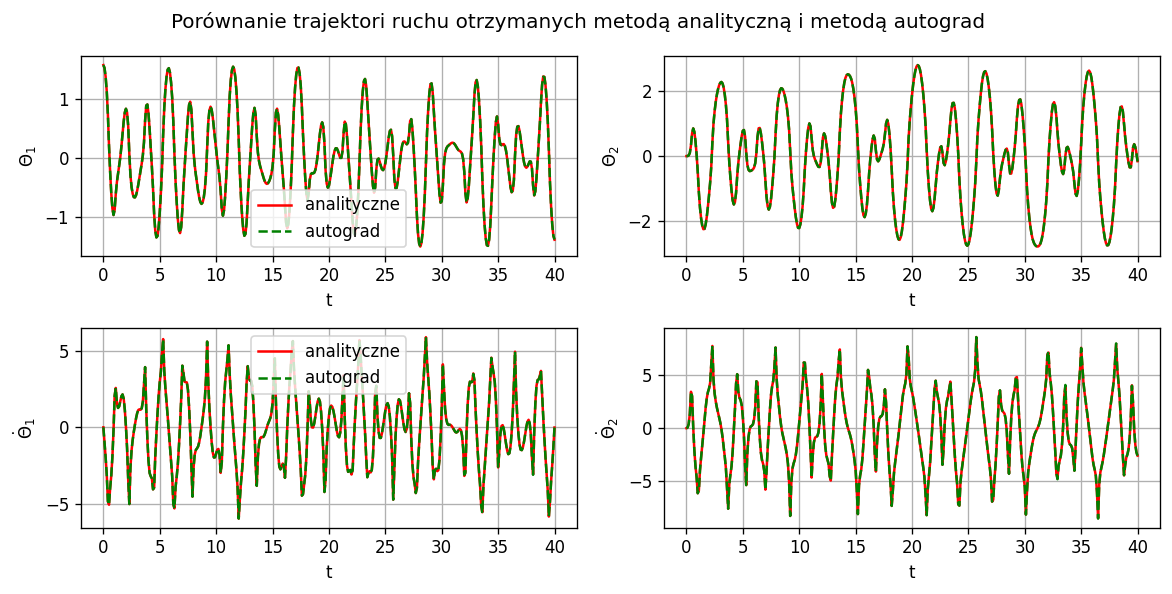

In [9]:
#PORÓWNANIE TRAJEKTORI OTRZYMANYCH PRZY UŻYCIU OBU METOD

fig, axes = plt.subplots(2, 2, figsize=(10, 5), dpi=120)
fig.suptitle('Porównanie trajektori ruchu otrzymanych metodą analityczną i metodą autograd')


#Kąt pierwszwego wahadła
axes[0,0].plot(t, analitical_clean[:, 0], 'r', label='analityczne')
axes[0,0].plot(t, autograd_clean[:, 0], 'g--', label='autograd')
axes[0,0].set_xlabel('t')
axes[0,0].set_ylabel('$\Theta_1$')
axes[0,0].legend()
axes[0,0].grid()

#Kąt drugiego wahadła
axes[0,1].plot(t, analitical_clean[:, 1], 'r', label='analityczne')
axes[0,1].plot(t, autograd_clean[:, 1], 'g--', label='autograd')
axes[0,1].set_xlabel('t')
axes[0,1].set_ylabel('$\Theta_2$')
axes[0,1].grid()

#Prędkość kątowa pierwszego wahadała
axes[1,0].plot(t, analitical_clean[:, 2], 'r', label='analityczne')
axes[1,0].plot(t, autograd_clean[:, 2], 'g--', label='autograd')
axes[1,0].set_xlabel('t')
axes[1,0].set_ylabel('$\dot \Theta_1$')
axes[1,0].legend()
axes[1,0].grid()

#Prędkość kątowa drugiego wahadła
axes[1,1].plot(t, analitical_clean[:, 3], 'r', label='analityczne')
axes[1,1].plot(t, autograd_clean[:, 3], 'g--', label='autograd')
axes[1,1].set_xlabel('t')
axes[1,1].set_ylabel('$\dot \Theta_2$')
axes[1,1].grid()


plt.tight_layout()

In [10]:
#Budowa zbioru uczącego i testowego
'''
N = 5             #liczba próbek pobieranych z jednej trajektorii
time_step = 0.2     #okres próbkowania
Num_X0_train = 100  #liczba trajektorii dla zbioru uczącego
Num_X0_test = 10    #liczba trajektorii dla zbioru testowego

new_data = False

x0_train = np.zeros([Num_X0_train, 4],  dtype=jnp.float32)
x0_test = np.zeros([Num_X0_test, 4],  dtype=jnp.float32)

#ZAKRESY
#Theta1 = <-Pi,Pi>
#Theta2 = <-Pi, Pi>
#Theta'1 = <-1, 1>
#Theta'2 = <-1, 1>

if new_data:

    eps = 0.1

    #Punkty startowe dla trajektorii dla zbioru uczącego
    x0_train[:,0] = np.random.rand(Num_X0_train)*2*(np.pi + eps) - (np.pi + eps)
    x0_train[:,1] = np.random.rand(Num_X0_train)*2*(np.pi + eps) - (np.pi + eps)
    x0_train[:,2] = np.random.rand(Num_X0_train)*2*1 - 1
    x0_train[:,3] = np.random.rand(Num_X0_train)*2*1 - 1

    #Punkty startowe dla trajektorii dla zbioru testowego
    x0_test[:,0] = np.random.rand(Num_X0_test)*2*(np.pi + eps) - (np.pi + eps)
    x0_test[:,1] = np.random.rand(Num_X0_test)*2*(np.pi + eps) - (np.pi + eps)
    x0_test[:,2] = np.random.rand(Num_X0_test)*2*1 - 1
    x0_test[:,3] = np.random.rand(Num_X0_test)*2*1 - 1
    t = jnp.linspace(0, N * time_step, num=N, dtype=jnp.float32)

    x_train = jnp.zeros([x0_train.shape[0]*N, 4])
    y_train = jnp.zeros([x0_train.shape[0]*N, 4])
    x_test = jnp.zeros([x0_test.shape[0]*N, 4])
    y_test = jnp.zeros([x0_test.shape[0]*N, 4])

    #Budowa zbioru uczącego
    for i in range(x0_train.shape[0]):
        trajectory = jax.device_get(solve_analitical(x0_train[i], t))
        trajectory = jax.vmap(normalize)(trajectory)
        x_train = x_train.at[i * N:(i + 1)*N, 0:4].set(trajectory)


        accelerations = jax.vmap(analitical)(trajectory)
        accelerations = jax.device_get(accelerations)
        y_train = y_train.at[i * N:(i + 1)*N, 0:2].set(accelerations[:,0,:])
        y_train = y_train.at[i * N:(i + 1)*N, 2:4].set(accelerations[:,1,:])

    #Budowa zbioru testowego
    for i in range(x0_test.shape[0]):
        trajectory = jax.device_get(solve_analitical(x0_test[i], t))
        trajectory = jax.vmap(normalize)(trajectory)
        x_test = x_test.at[i * N:(i + 1) * N, 0:4].set(trajectory)

        accelerations = jax.vmap(analitical)(trajectory)
        accelerations = jax.device_get(accelerations)
        y_test = y_test.at[i * N:(i + 1) * N, 0:2].set(accelerations[:,0,:])
        y_test = y_test.at[i * N:(i + 1) * N, 2:4].set(accelerations[:,1,:])

    #Zapis danych do pliku
    x_train_pd = pd.DataFrame(x_train)
    x_train_pd.to_csv("Dataset/x_train.csv", header=None)
    x_test_pd = pd.DataFrame(x_test)
    x_test_pd.to_csv("Dataset/x_test.csv", header=None)
    y_train_pd = pd.DataFrame(y_train)
    y_train_pd.to_csv("Dataset/y_train.csv", header=None)
    y_test_pd = pd.DataFrame(y_test)
    y_test_pd.to_csv("Dataset/y_test.csv", header=None)

else:

    x_train_pd = pd.read_csv("Dataset/x_train.csv", header=None)
    x_train = x_train_pd.to_numpy()
    x_test_pd = pd.read_csv("Dataset/x_test.csv", header=None)
    x_test = x_test_pd.to_numpy()
    y_train_pd = pd.read_csv("Dataset/y_train.csv", header=None)
    y_train = y_train_pd.to_numpy()
    y_test_pd = pd.read_csv("Dataset/y_test.csv", header=None)
    y_test = y_test_pd.to_numpy()

#Wizualizacja zbioru
fig, axes = plt.subplots(2, 2, figsize=(6, 3), dpi=120)

axes[0,0].scatter(x_train[:, 0], x_train[:, 2], s=6, alpha=0.5)
axes[1,0].scatter(x_train[:, 1], x_train[:, 3], s=6, alpha=0.5)
axes[0,1].scatter(x_test[:, 0], x_test[:, 2], s=6, alpha=0.5)
axes[1,1].scatter(x_test[:, 1], x_test[:, 3], s=6, alpha=0.5)

axes[0,0].set_xlabel('$\Theta_1$')
axes[0,0].set_ylabel('$\dot \Theta_1$')
axes[0,0].set_title('Zbiór uczący')
axes[0,0].grid()

axes[1,0].set_xlabel('$\Theta_2$')
axes[1,0].set_ylabel('$\dot \Theta_2$')
axes[1,0].set_title('Zbiór uczący')
axes[1,0].grid()

axes[0,1].set_xlabel('$\Theta_1$')
axes[0,1].set_ylabel('$\dot \Theta_1$')
axes[0,1].set_title('Zbiór testowy')
axes[0,1].grid()

axes[1,1].set_xlabel('$\Theta_2$')
axes[1,1].set_ylabel('$\dot \Theta_2$')
axes[1,1].set_title('Zbiór testowy')
axes[1,1].grid()

plt.tight_layout()
'''

'\nN = 5             #liczba próbek pobieranych z jednej trajektorii\ntime_step = 0.2     #okres próbkowania\nNum_X0_train = 100  #liczba trajektorii dla zbioru uczącego\nNum_X0_test = 10    #liczba trajektorii dla zbioru testowego\n\nnew_data = False\n\nx0_train = np.zeros([Num_X0_train, 4],  dtype=jnp.float32)\nx0_test = np.zeros([Num_X0_test, 4],  dtype=jnp.float32)\n\n#ZAKRESY\n#Theta1 = <-Pi,Pi>\n#Theta2 = <-Pi, Pi>\n#Theta\'1 = <-1, 1>\n#Theta\'2 = <-1, 1>\n\nif new_data:\n\n    eps = 0.1\n\n    #Punkty startowe dla trajektorii dla zbioru uczącego\n    x0_train[:,0] = np.random.rand(Num_X0_train)*2*(np.pi + eps) - (np.pi + eps)\n    x0_train[:,1] = np.random.rand(Num_X0_train)*2*(np.pi + eps) - (np.pi + eps)\n    x0_train[:,2] = np.random.rand(Num_X0_train)*2*1 - 1\n    x0_train[:,3] = np.random.rand(Num_X0_train)*2*1 - 1\n\n    #Punkty startowe dla trajektorii dla zbioru testowego\n    x0_test[:,0] = np.random.rand(Num_X0_test)*2*(np.pi + eps) - (np.pi + eps)\n    x0_test[:,1] =

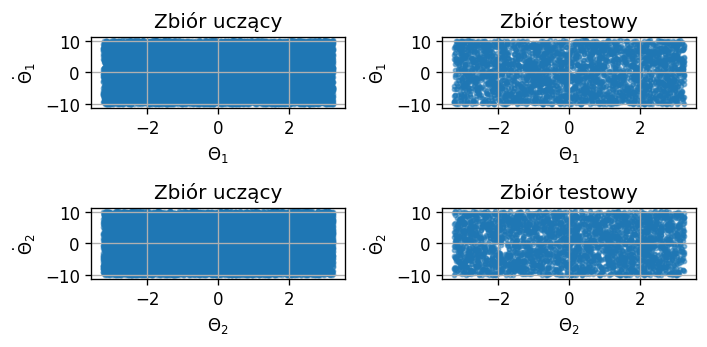

In [11]:
#BUDOWA ZBIORU UCZĄCEGO I TESTOWEGO NA PODSTAWIE WARTOŚCI LOSOWYCH

N=15000  #Liczność zbioru testowego i uczącego
test_train_rate = 0.8

new_data = True
noise_level = 0.0005
if new_data:
    eps = 0.1

    os.makedirs("Dataset", exist_ok=True)

    x_test_train = np.zeros([N, 4])
    y_test_train = np.zeros([N, 4])
    #Wyznaczenie losowych wartości położenia i prędkości
    x_test_train[:,0] = np.random.rand(N)*2*(np.pi + eps) - (np.pi + eps)
    x_test_train[:,1] = np.random.rand(N)*2*(np.pi + eps) - (np.pi + eps)
    x_test_train[:,2] = np.random.rand(N)*2*(10 + eps) - (10 + eps)
    x_test_train[:,3] = np.random.rand(N)*2*(10 + eps) - (10 + eps)
    #Obliczenie wartości wyjściowych (przyśpieszenia) dla otrzymanych losowych punktów położenia i prędkości
    #przy użyciu równania różniczkowego otrzymanego w sposób analityczny
    accelerations = jax.device_get(jax.vmap(analitical)(x_test_train))
    y_test_train[:, 0:2] = accelerations[:,0,:]
    y_test_train[:, 2:4] = accelerations[:,1,:]

    #Rozbicie zbioru na uczący i testowy
    x_train = x_test_train[0:int(N*test_train_rate)]
    y_train = y_test_train[0:int(N*test_train_rate)]

    x_test = x_test_train[int(N*test_train_rate):N]
    y_test = y_test_train[int(N*test_train_rate):N]

    #Zapis danych do pliku
    x_train_pd = pd.DataFrame(x_train)
    x_train_pd.to_csv("Dataset/x_train.csv", header=None, index=None)
    x_test_pd = pd.DataFrame(x_test)
    x_test_pd.to_csv("Dataset/x_test.csv", header=None, index=None)
    y_train_pd = pd.DataFrame(y_train)
    y_train_pd.to_csv("Dataset/y_train.csv", header=None, index=None)
    y_test_pd = pd.DataFrame(y_test)
    y_test_pd.to_csv("Dataset/y_test.csv", header=None, index=None)

else:

    x_train_pd = pd.read_csv("Dataset/x_train.csv", header=None)
    x_train = x_train_pd.to_numpy()
    x_test_pd = pd.read_csv("Dataset/x_test.csv", header=None)
    x_test = x_test_pd.to_numpy()
    y_train_pd = pd.read_csv("Dataset/y_train.csv", header=None)
    y_train = y_train_pd.to_numpy()
    y_test_pd = pd.read_csv("Dataset/y_test.csv", header=None)
    y_test = y_test_pd.to_numpy()

#Zaszumianie danych
noise_data  = noise_level*(np.random.rand(int(test_train_rate*N),4)*2-1)
x_train = x_train + noise_data
noise_data  = noise_level*(np.random.rand(int(test_train_rate*N),4)*2-1)
y_train = y_train + noise_data


#Wizualizacja zbioru
fig, axes = plt.subplots(2, 2, figsize=(6, 3), dpi=120)
axes[0,0].scatter(x_train[:, 0], x_train[:, 2], s=6, alpha=0.5)
axes[1,0].scatter(x_train[:, 1], x_train[:, 3], s=6, alpha=0.5)
axes[0,1].scatter(x_test[:, 0], x_test[:, 2], s=6, alpha=0.5)
axes[1,1].scatter(x_test[:, 1], x_test[:, 3], s=6, alpha=0.5)


axes[0,0].set_xlabel('$\Theta_1$')
axes[0,0].set_ylabel('$\dot \Theta_1$')
axes[0,0].set_title('Zbiór uczący')
axes[0,0].grid()

axes[1,0].set_xlabel('$\Theta_2$')
axes[1,0].set_ylabel('$\dot \Theta_2$')
axes[1,0].set_title('Zbiór uczący')
axes[1,0].grid()

axes[0,1].set_xlabel('$\Theta_1$')
axes[0,1].set_ylabel('$\dot \Theta_1$')
axes[0,1].set_title('Zbiór testowy')
axes[0,1].grid()

axes[1,1].set_xlabel('$\Theta_2$')
axes[1,1].set_ylabel('$\dot \Theta_2$')
axes[1,1].set_title('Zbiór testowy')
axes[1,1].grid()

plt.tight_layout()


In [12]:
#ARCHITEKUTRA SIECI NEURONOWEJ
#layers=[4,32,32,32,1]

#Klasa reprezentująca model
class NeuralNetwork(nn.Module):
  input_size:int
  output_size:int
  hidden_layer:int
  layer_size:int

  #Metoda definiująca architekturę sieci
  def setup(self):
    kernel_init = nn.initializers.variance_scaling(scale=2.0, mode='fan_avg', distribution='truncated_normal')
    self.Dense = [nn.Dense(features=self.layer_size) for i in range(self.hidden_layer)]
    self.BatchNorm = [nn.BatchNorm() for i in range(self.hidden_layer)]
    self.Output = nn.Dense(self.output_size)

  #Metoda definiująca przejście danych przez sieć
  def __call__(self, x, train:bool):
    for i in range(self.hidden_layer):
      x = self.BatchNorm[i](x, use_running_average=not train)
      x = self.Dense[i](x)
      x = nn.softplus(x)
    x = self.Output(x)
    return x

  #Metoda inicjalizująca początkowe parametry sieci
  def init_params(self, key):
    variables = self.init(key, jnp.ones((self.input_size)), train=False)
    return variables['params'], variables['batch_stats']

  #Metoda modelująca lagrangian (wyjście sieci neuronowej)
  #Argumenty:
  #   params - parametry sieci neuronowej
  #   q, q_t - wektor wartości wejściowych dla sieci (położenie, przyśpieszenie)
  #Zwraca:
  #   lagrangian - wartość lagrangianu dla danego wektora stanu
  def learned_lagrangian(self, params, batch_stats):
    def lagrangian(q, q_t):
        assert q.shape == (2,)
        state = jnp.concatenate([q, q_t])
        return  jnp.squeeze(self.apply({'params': params, 'batch_stats': batch_stats}, state, train=False), axis=-1)

    return lagrangian


  def batch_norm_updates(self, params, batch_stats, state):
    _, updates = self.apply({'params': params, 'batch_stats': batch_stats}, state, train=True, mutable=['batch_stats'])
    return updates




#DEFINICJA BŁĘDU DLA SIECI
#Argumenty:
#   train_state - Obiekt klasy train_state
#   params      - parametry sieci neuronowej
#   state       - wektor stanu [położenie, prędkość]
#   target      - oczekiwany wektor wyjściowy sieci [prędkość, przyśpieszenie]
#Zwracane:
#   Błąd średniokwadratowy zadanego batcha
def MSE_loss(train_state, params, batch_stats, state, targets):
  preds = jax.vmap(partial(equation_of_motion, train_state.apply_fn.learned_lagrangian(params, batch_stats)))(state)
  return jnp.mean((preds - targets) ** 2)


#Funkcja realizująca krok uczenia sieci zadanym batchem
#Argumenty:
#   train_state - Obiekt klasy train_state
#   state       - wektor stanu [położenie, prędkość]
#   target      - oczekiwany wektor wyjściowy sieci [prędkość, przyśpieszenie]
#Zwracane:
#   train_state - Obiekt klasy train_state z wagami zmienionymi po uczeniu
#   loss        - Błąd średniokwadratowy dla zadanego batcha
@jax.jit
def train_step(train_state, state, targets):

    grad_fn = jax.value_and_grad(MSE_loss, argnums=1)
    loss, grads = grad_fn(train_state, train_state.params, train_state.batch_stats, state, targets)
    updates =  train_state.apply_fn.batch_norm_updates(train_state.params, train_state.batch_stats, state)

    train_state = train_state.apply_gradients(grads=grads)
    train_state = train_state.replace(batch_stats=updates['batch_stats'])

    return train_state, loss


#Funkcja zamieniająca losowe elementy 2 wektorów w ten sam sposób.
#Argumenty:
#   a, b - Wektory, które mają zostać przemieszane.
#Zawracane:
#   a, b - Przetasowane wektory.
def shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(a.shape[0])
    return a[p], b[p]

In [13]:
%%time

Training = False         #Uczenie sieci
Continuing = False       #Kontynuacja uczenia na podstawie zapisanych wag
Epochs = 10000           #Liczba epok
StopError = 0.001       #Warunek stopu (Błąd MSE na zbiorze testowym)
learning_rate = 1e-3    #Współczynnik uczenia
batch_size = 32        #Rozmiar batcha

train_error=[]      #Wektor błędów MSE dla zbioru uczącego
test_error=[]       ##Wektor błędów MSE dla zbioru testowego


#Stworzenie modelu oraz inicjalizacja wag i biasów
model = NeuralNetwork(input_size=4, output_size=1, hidden_layer=2, layer_size=128)
rng = jax.random.PRNGKey(0)
params, batch_stats = model.init_params(rng)

#Ścieżka do zapisu modelu
ckpt_dir = os.path.abspath('Checkpoints')
data_set_name = 'DP_00005_'


#Wybór optymalizatora
optimizer = optax.adam(learning_rate=learning_rate)

#Inicjalizacja obiektu klasy train_state, która wspomaga proces uczenia modelu
class TrainState(train_state.TrainState):
  batch_stats: Any


model_state = TrainState.create(
  apply_fn=model,
  params=params,
  batch_stats=batch_stats,
  tx=optimizer
)

#Kontynuacja uczenia
if Continuing:
  checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=model_state, prefix=data_set_name)
  params = model_state.params
  batch_stats = model_state.batch_stats
  model_state = model_state.replace(
        params=params,
        batch_stats=batch_stats
    )




#Wykonanie uczenia sieci
if Training:

    x_train, x_test, y_train, y_test = map(jax.device_get, [x_train, x_test, y_train, y_test])
    n_samples =  x_train.shape[0]
    best_error = float('inf')

    for i in range(Epochs):
        #Realizacja minibatcha
        x_train, y_train = shuffle(x_train, y_train)
        start = 0
        loss = 0
        full_batch = 0

        while start < n_samples:
            #Podział danych na batche
            end = start + batch_size
            x_batch = x_train[start:end, :]
            y_batch = y_train[start:end, :]

            #Obliczenie błędu MSE i optymalizacja wag
            model_state, act_loss = train_step(model_state, x_batch, y_batch)
            loss += act_loss
            start += batch_size

        #Zapisanie błędu na podstawie zbioru uczącego i testowego w każdej epoce
        train_error.append(loss / (float(start+batch_size) /  float(batch_size)))
        test_error.append(MSE_loss(model_state, model_state.params, model_state.batch_stats, x_test, y_test))

        #Zapamiętywanie najlepszych parametrów sieci
        if test_error[-1] < best_error:
            best_error = test_error[-1]
            best_params = model_state.params
            best_batch_stats = model_state.batch_stats

        #Wcześciejsze kończenie uczenia
        if test_error[-1] <= StopError:
            print(f"iteration={i}, train_loss={train_error[-1]:.6f}, test_loss={test_error[-1]:.6f}, best_loss={best_error:.6f}")
            break

        #Wyświetlanie informacji o postępie uczenia
        if i % 1 == 0:
            print(f"iteration={i}, train_loss={train_error[-1]:.6f}, test_loss={test_error[-1]:.6f}, best_loss={best_error:.6f}")

    #Wybór najlepszych parametrów
    params = best_params
    batch_stats = best_batch_stats
    model_state = model_state.replace(
        params=params,
        batch_stats=batch_stats
    )

    #Zapisanie parametrów do pliku
    os.makedirs('Checkpoints', exist_ok=True)
    checkpoints.save_checkpoint(ckpt_dir=ckpt_dir,
                            target=model_state,
                            step=len(test_error),
                            prefix=data_set_name,
                            overwrite=True
                           )
#Brak uczenia - odczyt parametrów z pliku
else:
    loaded_model_state = checkpoints.restore_checkpoint(
                                             ckpt_dir=ckpt_dir,
                                             target=model_state,
                                             prefix=data_set_name
                                            )
    params = loaded_model_state.params
    batch_stats = loaded_model_state.batch_stats



CPU times: user 4.01 s, sys: 326 ms, total: 4.34 s
Wall time: 3.95 s


In [14]:
#Funkcja wyznaczająca trajektorię ruchu przy użyciu Lagrangianu zamodlowanego za pomocą sieci neuronowej
#Argumenty funkcji:
#   -model         - Obiekt reprezentujący sieć
#   -params        - Parametry sieci neuronowej
#   -initial_state - Początkowego położenie oraz prędkości
#   -times         - Czas wyznaczanej trajektori
#Zwraca:
#   Wektor trajektori ruchu w zależności od czasu
#@partial(jax.jit, backend='cpu')
def solve_lagrangian(model, params, batch_stats, initial_state, times):
  return odeint(partial(equation_of_motion, model.learned_lagrangian(params, batch_stats)),
                  initial_state, times, rtol=1e-10, atol=1e-10)


#Funkcja ma za zadanie obliczenie przyśpieszenia na podstawie aktualnego stanu
#(położenie i przyśpieszenie) przy użyciu lagrangianu zamodelowanego przez sieć LNN.
#Argumenty funkcji:
#   -model      - Obiekt reprezentujący sieć
#   -params     - Parametry sieci.
#   -state      - Wektor zawierający wartości początkowe położenia i prędkości [q, q_t].
#Zwracane:  Przyśpieszenie wynikającego z aktulanego wektora stanu.
#@partial(jax.jit, backend='cpu')
def acceleration_learned(model, params, batch_stats, state):
  return jax.vmap(partial(equation_of_motion, model.learned_lagrangian(params, batch_stats)))(state)

In [15]:
#Zapis błędów do pliku
if Training:
    os.makedirs('Errors', exist_ok=True)
    train_error_pd = pd.DataFrame(train_error)
    train_error_pd.to_csv("Errors/train_error1.csv", header=None)
    test_error_pd = pd.DataFrame(test_error)
    test_error_pd.to_csv("Errors/test_error1.csv", header=None)
else:
    train_error_pd = pd.read_csv("Errors/train_error1.csv", header=None)
    train_error = list(train_error_pd[train_error_pd.columns[-1]])
    test_error_pd = pd.read_csv("Errors/test_error1.csv", header=None)
    test_error = list(test_error_pd[test_error_pd.columns[-1]])

In [16]:
#!zip -r /content/Data.zip /content/Checkpoints/ /content/Errors/ /content/Dataset
#files.download("/content/Data.zip")

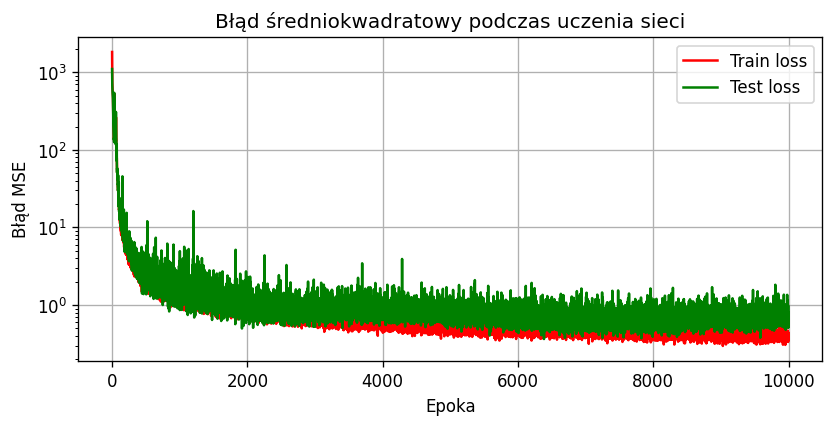

In [17]:
#WIZUALIZACJA BŁĘDU MSE PODCZAS UCZENIA SIECI

plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_error[:], 'r', label='Train loss')
plt.plot(test_error[:], 'g', label='Test loss')
plt.yscale('log')
plt.title('Błąd średniokwadratowy podczas uczenia sieci')
plt.xlabel("Epoka")
plt.ylabel("Błąd MSE")
plt.grid()
plt.legend()
plt.show()

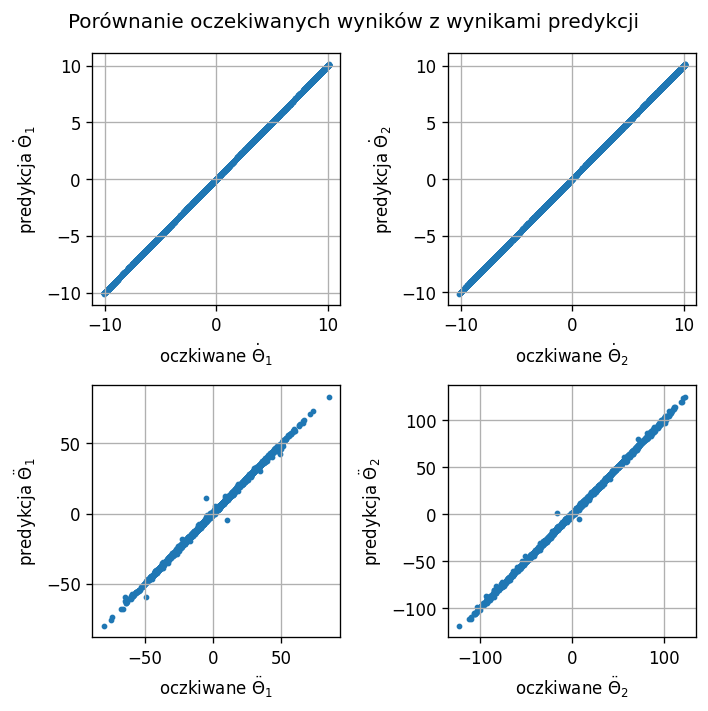

In [18]:
#TEST PREDYKCJI SIECI

#Obliczenie predykcji sieci (wartość wyjściowa) na podstawie zbioru testowego
y_pred = acceleration_learned(model, params, batch_stats, x_test)

#Wizualizacji wyników
fig, axes = plt.subplots(2, 2, figsize=(6, 6), dpi=120)
fig.suptitle("Porównanie oczekiwanych wyników z wynikami predykcji")
axes[0,0].scatter(y_test[:, 0], y_pred[:, 0], s=6, alpha=1)
axes[0,0].set_xlabel('oczkiwane $\dot \Theta_1$')
axes[0,0].set_ylabel('predykcja $\dot \Theta_1$')
axes[0,0].grid()
axes[0,1].scatter(y_test[:, 1], y_pred[:, 1], s=6, alpha=1)
axes[0,1].set_xlabel('oczkiwane $\dot \Theta_2$')
axes[0,1].set_ylabel('predykcja $\dot \Theta_2$')
axes[0,1].grid()
axes[1,0].scatter(y_test[:, 2], y_pred[:, 2], s=6, alpha=1)
axes[1,0].set_xlabel('oczkiwane $\ddot \Theta_1$')
axes[1,0].set_ylabel('predykcja $\ddot \Theta_1$')
axes[1,0].grid()
axes[1,1].scatter(y_test[:, 3], y_pred[:, 3], s=6, alpha=1)
axes[1,1].set_xlabel('oczkiwane $\ddot \Theta_2$')
axes[1,1].set_ylabel('predykcja $\ddot \Theta_2$')
axes[1,1].grid()
plt.tight_layout()

In [19]:

#Punkt startowy
x0 = jnp.array([1,1.3,0,2], dtype=np.float32)
#Szum
noise = np.random.RandomState(0).randn(x0.size)
#Wektor czasów
t = np.linspace(0, 40, num=401, dtype=np.float32)


%time trajectory_autograd = jax.device_get(solve_analitical(x0, t))

%time trajectory_LNN = jax.device_get(solve_lagrangian(model, params, batch_stats, x0, t))

CPU times: user 82.7 ms, sys: 8.34 ms, total: 91 ms
Wall time: 102 ms
CPU times: user 55.1 s, sys: 83.9 ms, total: 55.1 s
Wall time: 55.3 s


In [20]:
#OBLICZENIE BŁĘDÓW
import bisect
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import mean_absolute_error as MAE
import csv

rmse = np.zeros([4])
mae = np.zeros([4])

#obliczenie błędów
time_idx = bisect.bisect_right(t, 10)
for j in range(4):
    rmse[j] = RMSE(trajectory_autograd[:time_idx,j], trajectory_LNN[:time_idx,j])
    mae[j] =  MAE(trajectory_autograd[:time_idx,j], trajectory_LNN[:time_idx,j])

output = [noise_level] + rmse.tolist() + mae.tolist()  # Combine noise_level, rmse, and mae into a single list
print(output)

with open("../Wyniki.csv", mode='a', newline='') as file:  # 'a' mode is for appending
    writer = csv.writer(file)
    writer.writerow(output)
    

[0.0005, 0.3499273657798767, 0.545026421546936, 1.7418748140335083, 2.548576593399048, 0.27245840430259705, 0.42732417583465576, 1.332975149154663, 2.048051595687866]


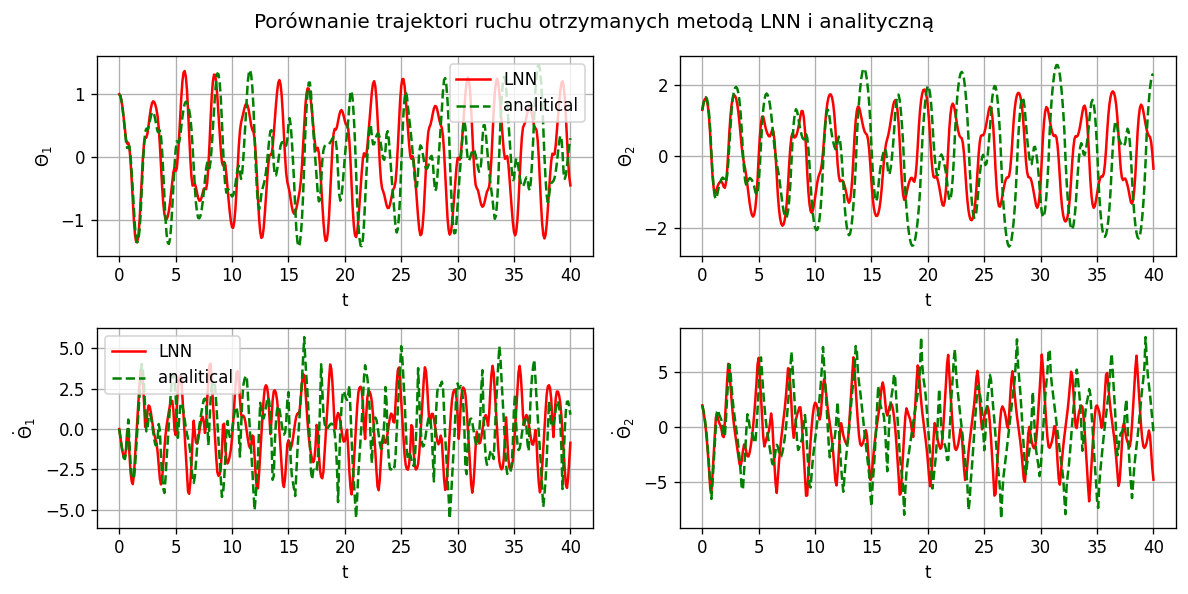

In [21]:
#PORÓWNANIE TRAJEKTORI OTRZYMANYCH PRZY UŻYCIU OBU METOD

fig, axes = plt.subplots(2, 2, figsize=(10, 5), dpi=120)
fig.suptitle('Porównanie trajektori ruchu otrzymanych metodą LNN i analityczną')


#Kąt pierwszwego wahadła
axes[0,0].plot(t, trajectory_LNN[:, 0], 'r', label='LNN')
axes[0,0].plot(t, trajectory_autograd[:, 0], 'g--', label='analitical')
axes[0,0].set_xlabel('t')
axes[0,0].set_ylabel('$\Theta_1$')
axes[0,0].legend()
axes[0,0].grid()

#Kąt drugiego wahadła
axes[0,1].plot(t, trajectory_LNN[:, 1], 'r', label='LNN')
axes[0,1].plot(t, trajectory_autograd[:, 1], 'g--', label='analitical')
axes[0,1].set_xlabel('t')
axes[0,1].set_ylabel('$\Theta_2$')
axes[0,1].grid()

#Prędkość kątowa pierwszego wahadała
axes[1,0].plot(t, trajectory_LNN[:, 2], 'r', label='LNN')
axes[1,0].plot(t, trajectory_autograd[:, 2], 'g--', label='analitical')
axes[1,0].set_xlabel('t')
axes[1,0].set_ylabel('$\dot \Theta_1$')
axes[1,0].legend()
axes[1,0].grid()

#Prędkość kątowa drugiego wahadła
axes[1,1].plot(t, trajectory_LNN[:, 3], 'r', label='LNN')
axes[1,1].plot(t, trajectory_autograd[:, 3], 'g--', label='analitical')
axes[1,1].set_xlabel('t')
axes[1,1].set_ylabel('$\dot \Theta_2$')
axes[1,1].grid()


plt.tight_layout()

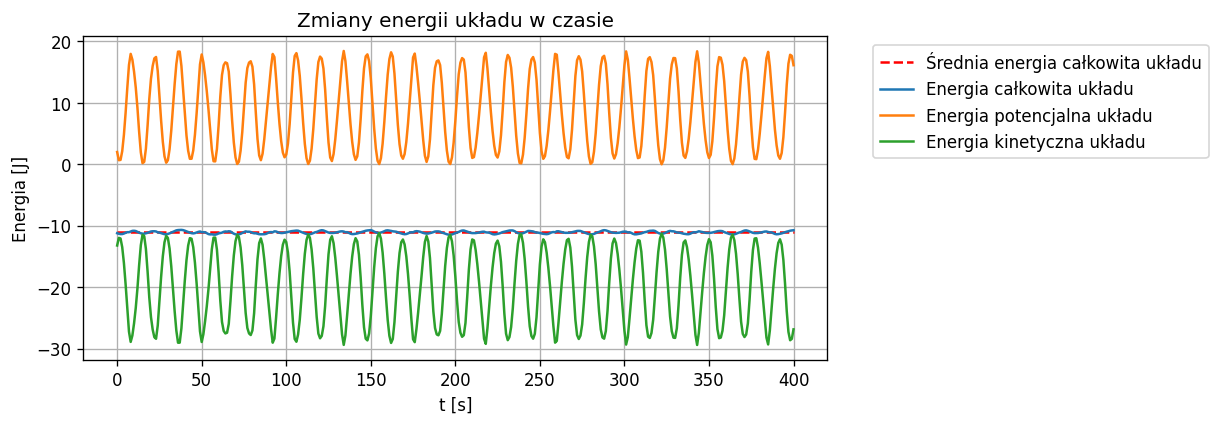

In [22]:
#Wyznaczenie Energi potencjalnej i kinetycznej trajektorii

q, q_t = jnp.hsplit(trajectory_LNN, 2)
Ep, Ek = jax.vmap(compute_energy)(q, q_t)
Ec=Ep+Ek
mean = jnp.mean(Ec)
mean_Ec = jnp.ones(Ec.shape, dtype=jnp.float32) * jnp.mean(Ec)

plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(mean_Ec, 'r--', label="Średnia energia całkowita układu")
plt.plot(Ec, label="Energia całkowita układu")
plt.plot(Ep, label="Energia potencjalna układu")
plt.plot(Ek, label="Energia kinetyczna układu")
plt.title('Zmiany energii układu w czasie')
plt.xlabel("t [s]")
plt.ylabel("Energia [J]")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()
plt.show()